# GP

In [19]:
%matplotlib inline

# Setup environment collect data

In [20]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500, render_mode="rgb_array")

# Dynamics from GP

In [2]:
# Part A — Collect data with a random policy (Gymnasium)
import numpy as np
import gymnasium as gym

def collect_random_data(env_name="MountainCarContinuous-v0", N=1000, seed=0, save_path=None):
    """
    Returns:
      X      : (N, S)    states x_t
      U      : (N, A)    actions u_t
      R      : (N,)      rewards r_t
      X_next : (N, S)    next states x_{t+1}
      dX     : (N, S)    state differences x_{t+1} - x_t
    """
    rng = np.random.default_rng(seed)
    env = gym.make(env_name)
    obs, _ = env.reset(seed=seed)

    S = env.observation_space.shape[0]
    A = env.action_space.shape[0]
    low, high = env.action_space.low, env.action_space.high

    X      = np.zeros((N, S), dtype=np.float32)
    U      = np.zeros((N, A), dtype=np.float32)
    R      = np.zeros((N,),   dtype=np.float32)
    X_next = np.zeros((N, S), dtype=np.float32)

    i = 0
    while i < N:
        # sample a random action uniformly over the valid bounds
        u = rng.uniform(low=low, high=high, size=A).astype(np.float32)

        obs_next, r, terminated, truncated, _ = env.step(u)

        X[i]      = obs
        U[i]      = u
        R[i]      = r
        X_next[i] = obs_next

        obs = obs_next
        done = terminated or truncated
        if done:
            obs, _ = env.reset()

        i += 1

    env.close()
    dX = X_next - X

    if save_path is not None:
        np.savez_compressed(save_path, X=X, U=U, R=R, X_next=X_next, dX=dX)
        print(f"Saved dataset to {save_path}")

    return X, U, R, X_next, dX

# Example run
if __name__ == "__main__":
    X, U, R, X_next, dX = collect_random_data(N=1000, seed=42, save_path="gp_mpc_random_data.npz")
    print("Shapes -> X:", X.shape, "U:", U.shape, "R:", R.shape, "X_next:", X_next.shape, "dX:", dX.shape)
    # quick sanity check: mean/var of dX
    print("dX mean:", dX.mean(axis=0), " | dX std:", dX.std(axis=0))


Saved dataset to gp_mpc_random_data.npz
Shapes -> X: (1000, 2) U: (1000, 1) R: (1000,) X_next: (1000, 2) dX: (1000, 2)
dX mean: [-3.2732653e-04  2.8187775e-05]  | dX std: [0.014118   0.00145227]


Loaded dataset from gp_mpc_random_data.npz  shapes -> X(1000, 2), U(1000, 1), dX(1000, 2)

=== Training GP for Δx[0] ===
iter  100  nll=-1.685
iter  200  nll=-3.401
iter  300  nll=-3.585
iter  400  nll=-3.617
iter  500  nll=-3.630
iter  600  nll=-3.632
iter  700  nll=-3.641
iter  800  nll=-3.642
iter  900  nll=-3.647
iter 1000  nll=-3.646
iter 1100  nll=-3.649
iter 1200  nll=-3.645
iter 1300  nll=-3.650
iter 1400  nll=-3.595
iter 1500  nll=-3.648
iter 1600  nll=-3.651
iter 1700  nll=-3.653
iter 1800  nll=-3.648
iter 1900  nll=-3.651
iter 2000  nll=-3.653

=== Training GP for Δx[1] ===
iter  100  nll=-1.648
iter  200  nll=-3.326
iter  300  nll=-3.518
iter  400  nll=-3.556
iter  500  nll=-3.572
iter  600  nll=-3.582
iter  700  nll=-3.589
iter  800  nll=-3.593
iter  900  nll=-3.597
iter 1000  nll=-3.600
iter 1100  nll=-3.602
iter 1200  nll=-3.604
iter 1300  nll=-3.606
iter 1400  nll=-3.607
iter 1500  nll=-3.609
iter 1600  nll=-3.610
iter 1700  nll=-3.611
iter 1800  nll=-3.612
iter 1900  n

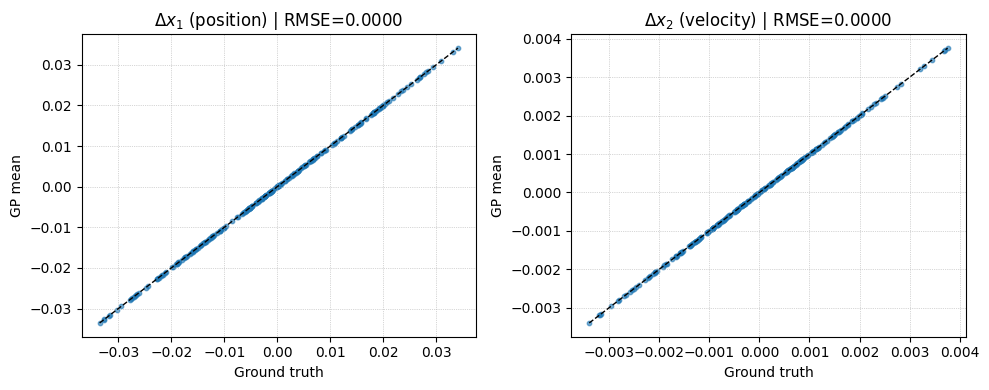

In [6]:
# Part B — Train a Gaussian Process model with GPyTorch
import os
import numpy as np 
import torch
import gpytorch
import matplotlib.pyplot as plt

# ---------- A) Load (or create) data ----------
def load_or_make_data(path="gp_mpc_random_data.npz", N=1000, seed=42):
    try:
        D = np.load(path)
        X, U, dX = D["X"], D["U"], D["dX"]
        print(f"Loaded dataset from {path}  shapes -> X{X.shape}, U{U.shape}, dX{dX.shape}")
    except FileNotFoundError:
        import gymnasium as gym
        rng = np.random.default_rng(seed)
        env = gym.make("MountainCarContinuous-v0")
        obs, _ = env.reset(seed=seed)
        S, A = env.observation_space.shape[0], env.action_space.shape[0]
        low, high = env.action_space.low, env.action_space.high
        X = np.zeros((N, S), np.float32); U = np.zeros((N, A), np.float32); Xn = np.zeros_like(X)
        i = 0
        while i < N:
            u = rng.uniform(low=low, high=high, size=A).astype(np.float32)
            obs_next, _, term, trunc, _ = env.step(u)
            X[i] = obs; U[i] = u; Xn[i] = obs_next
            obs = obs_next
            if term or trunc: obs, _ = env.reset()
            i += 1
        env.close()
        dX = Xn - X
        np.savez_compressed(path, X=X, U=U, R=np.zeros(N), X_next=Xn, dX=dX)
        print(f"Generated and saved dataset to {path}")
    return X, U, dX

X, U, dX = load_or_make_data()
Z = np.concatenate([X, U], axis=1).astype(np.float32)   # inputs [pos, vel, action], shape (N,3)
Y = dX.astype(np.float32)                                # targets Δx, shape (N,2)

# ---------- B) Torch tensors & train/test split ----------
device = torch.device("cuda")
torch.manual_seed(0)
N = Z.shape[0]
perm = torch.randperm(N)
split = int(0.75 * N)
idx_tr, idx_te = perm[:split], perm[split:]

Zt = torch.from_numpy(Z).to(device)
Yt = torch.from_numpy(Y).to(device)

Z_tr, Z_te = Zt[idx_tr], Zt[idx_te]
Y_tr, Y_te = Yt[idx_tr], Yt[idx_te]

# ---------- C) Standardize (affine normalize) ----------
z_mean, z_std = Z_tr.mean(0), Z_tr.std(0).clamp_min(1e-6)
y_mean, y_std = Y_tr.mean(0), Y_tr.std(0).clamp_min(1e-6)

def z_norm(z): return (z - z_mean) / z_std
def y_norm(y): return (y - y_mean) / y_std
def y_unnorm(yn): return yn * y_std + y_mean

Z_tr_n, Z_te_n = z_norm(Z_tr), z_norm(Z_te)
Y_tr_n = y_norm(Y_tr)

# ---------- D) GP model (ExactGP) ----------
class AffineMean(gpytorch.means.Mean):
    """Linear + bias mean: m(z) = w^T z + b  (avoids ConstantMean()+LinearMean issue)"""
    def __init__(self, input_size):
        super().__init__()
        self.register_parameter(name="weights", parameter=torch.nn.Parameter(torch.zeros(input_size)))
        self.register_parameter(name="bias", parameter=torch.nn.Parameter(torch.zeros(1)))
    def forward(self, x):
        return x.matmul(self.weights) + self.bias

class SingleOutputExactGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = AffineMean(train_x.shape[-1])
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[-1])
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp(train_x, train_y, iters=800, lr=0.05):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = SingleOutputExactGP(train_x, train_y, likelihood).to(device)
    model.train(); likelihood.train()
    opt = torch.optim.Adam([{'params': model.parameters()}], lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(iters):
        opt.zero_grad(set_to_none=True)
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        opt.step()
        if (i+1) % 100 == 0:
            print(f"iter {i+1:4d}  nll={loss.item():.3f}")
    return model, likelihood

# Train two independent GPs: one for Δpos, one for Δvel
gp_models = []
for j in range(Y.shape[1]):
    print(f"\n=== Training GP for Δx[{j}] ===")
    yj = Y_tr_n[:, j]
    m, lk = fit_gp(Z_tr_n, yj, iters=2000, lr=0.05)
    gp_models.append((m.eval(), lk.eval()))

# ---------- E) Predict on test and compute RMSE ----------
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_s = []
    for (m, lk) in gp_models:
        dist = m(Z_te_n)
        mean = lk(dist).mean  # mean of predictive (same as dist.mean for GaussianLikelihood)
        preds_s.append(mean)
    Y_pred_n = torch.stack(preds_s, dim=1)
    Y_pred = y_unnorm(Y_pred_n)

rmse = torch.sqrt(torch.mean((Y_pred - Y_te)**2, dim=0))
print(f"\nRMSE per state-dimension on Δx (units of state): {rmse.cpu().numpy()}")

# ---------- F) Parity plots ----------
Y_te_np = Y_te.detach().cpu().numpy()
Y_pr_np = Y_pred.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
labels = [r"$\Delta x_1$ (position)", r"$\Delta x_2$ (velocity)"]
for j, ax in enumerate(axes):
    ax.scatter(Y_te_np[:, j], Y_pr_np[:, j], s=10, alpha=0.6)
    lo = float(min(Y_te_np[:, j].min(), Y_pr_np[:, j].min()))
    hi = float(max(Y_te_np[:, j].max(), Y_pr_np[:, j].max()))
    ax.plot([lo, hi], [lo, hi], 'k--', lw=1)
    ax.set_xlabel("Ground truth")
    ax.set_ylabel("GP mean")
    ax.set_title(f"{labels[j]} | RMSE={rmse[j].item():.4f}")
    ax.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()


# Callback for GP dynamics

In [4]:
# ---------- G) Convenience: callable GP dynamics (mean prediction) ----------
def gp_dynamics_predict(x, u):
    """
    x: (...,2) state [pos, vel]
    u: (...,1) action
    returns mean Δx (...,2) as torch tensor on current device
    """
    z = torch.cat([torch.as_tensor(x, dtype=torch.float32, device=device).reshape(-1, 2),
                   torch.as_tensor(u, dtype=torch.float32, device=device).reshape(-1, 1)], dim=1)
    z_n = (z - z_mean) / z_std
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        outs = []
        for (m, lk) in gp_models:
            outs.append(lk(m(z_n)).mean)
        dx_n = torch.stack(outs, dim=1)
    return dx_n * y_std + y_mean  # unnormalize

# Roll trajectories over the GP model

### Cost Function

In [470]:
# import torch

# @torch.no_grad()
# def cost_fn_torch(
#     x, a, a_prev=None,
#     *, goal=0.45,
#     # running costs
#     qx=80.0, qv=1.0, r=0.08, r_du=0.05,
#     # goal band shaping
#     band=0.01, v_tol=0.01, qx_band=600.0, qv_band=40.0,
#     # terminal costs
#     qx_T=1200.0, qv_T=200.0, arrival_bonus=-300.0,
#     is_terminal_mask=None
# ):
#     """
#     x: (...,2) [pos, vel]
#     a: (...,1)
#     a_prev: (...,1) or None  -> for slew penalty
#     is_terminal_mask: (...,) bool or None -> mark final step(s) in horizon
#     returns: (...) per-step cost
#     """
#     pos = x[..., 0]
#     vel = x[..., 1]
#     err = goal - pos

#     # Basic quadratic running costs
#     cost = qx*(err**2) + qv*(vel**2) + r*(a[..., 0]**2)

#     # Slew penalty (Δu)
#     if a_prev is not None:
#         du = a[..., 0] - a_prev[..., 0]
#         cost = cost + r_du*(du**2)

#     # Goal band shaping: penalize leaving a tight region; damp velocity near goal
#     dist = torch.abs(err)
#     out_of_band = torch.relu(dist - band)                       # distance outside band
#     cost = cost + qx_band*(out_of_band**2) + qv_band*(vel**2)*(dist < band)

#     # Terminal cost (very strong at horizon end)
#     if is_terminal_mask is not None:
#         term = qx_T*(err**2) + qv_T*(vel**2)

#         # Arrival bonus if we're in the band and nearly stopped
#         arrived = (dist <= band) & (torch.abs(vel) <= v_tol)
#         term = term + arrival_bonus*arrived

#         cost = cost + is_terminal_mask*term

#     return cost





# import torch

# def cost_fn_torch(x, a, x_star=0.45, w_pos=20.0, w_vel=10.0, w_act=1.5):
#     """
#     x: (..., 2) tensor [pos, vel]
#     a: (..., 1) tensor (actions in [-1, 1] recommended)
#     returns: (...) tensor of per-step costs
#     """
#     pos = x[..., 0]
#     vel = x[..., 1]
#     act = a[..., 0]

#     pos_err = pos - x_star
#     act_clip = torch.clamp(act, -1.0, 1.0)

#     return w_pos * (pos_err ** 2) + w_vel * (vel ** 2) + w_act * (act_clip ** 2)



# import torch

# ENERGY_WEIGHTS = dict(
#     position   = 200.0,
#     velocity   = 500.0,
#     energy     = 20.0,
#     stop_boost = 5000.0,
#     time       = 1.0,
# )

# def cost_fn_torch(x, a, goal=0.45, weights=ENERGY_WEIGHTS):
#     """
#     x: (..., 2) tensor [pos, vel]
#     a: (..., 1) tensor (actions, typically in [-1, 1])
#     returns: (...) tensor of per-step costs
#     """
#     w = weights
#     pos = x[..., 0]
#     vel = x[..., 1]
#     act = torch.clamp(a[..., 0], -1.0, 1.0)          # keep action bounded, then square

#     dist = torch.abs(pos - goal)
#     pos_term = w["position"] * (torch.tanh(dist * 2.0) ** 2)               # tanh^2 shaping
#     vel_weight = w["velocity"] + w["stop_boost"] * torch.exp(-20.0 * dist) # heavier near goal
#     vel_term = vel_weight * (vel ** 2)
#     energy_term = w["energy"] * (act ** 2)
#     time_term = w['time'] #torch.as_tensor(w["time"], dtype=x.dtype, device=x.device)

#     # big negative “steady” bonus when near goal and almost stopped
#     steady_mask = (dist < 0.03) & (torch.abs(vel) < 0.005)
#     steady_term = torch.where(steady_mask,
#                               torch.as_tensor(-1000.0, dtype=x.dtype, device=x.device),
#                               torch.as_tensor(0.0,     dtype=x.dtype, device=x.device))

#     return pos_term + vel_term + energy_term + time_term + steady_term





# import torch

# def cost_fn_torch(
#     x, a, *,
#     goal=0.45,
#     # position shaping (saturating so it still swings for momentum)
#     w_pos=500.0, tanh_gain=2.0,
#     # baseline penalties
#     w_vel=100.0, w_act=1.0,
#     # near-goal braking & holding (you used these already)
#     beta=100.0,           # exp(-beta*dist) gate; big => only close to goal
#     w_v_near=15000.0,     # strong brake near goal
#     w_hold=6000.0,        # track equilibrium torque near goal
#     # NEW: braking cone & overshoot
#     k_cone=0.55,          # allowed |v| <= k_cone * sqrt(dist)
#     w_cone=18000.0,       # penalty on violating the cone
#     w_overshoot=22000.0,  # penalty for x > goal (right of flag)
#     # arrival bonus band
#     band_bonus=-300.0, band_pos=0.012, band_vel=0.010,
#     # per-step constant & softmax conditioning
#     w_time=0.0, scale=7.0
# ):
#     """
#     x: (...,2) [pos, vel], a: (...,1) in [-1,1]
#     returns per-step cost (...,)
#     """
#     pos = x[..., 0]
#     vel = x[..., 1]
#     u   = torch.clamp(a[..., 0], -1.0, 1.0)

#     # distance and near-goal gate
#     dist = (pos - goal).abs()
#     near = torch.exp(-beta * dist)  # ~1 very close, ~0 far

#     # --- position shaping (saturating) ---
#     pos_term = w_pos * (torch.tanh(tanh_gain * dist) ** 2)

#     # --- baseline velocity & action ---
#     base = w_vel * (vel**2) + w_act * (u**2)

#     # --- strong near-goal braking ---
#     v_near_term = w_v_near * near * (vel**2)

#     # --- equilibrium hold torque (cancel gravity) near goal ---
#     # MountainCar discrete: dv ≈ 0 when u_eq = (0.0025/0.0015)*cos(3x) ≈ 1.6667*cos(3x)
#     u_eq = 1.6666667 * torch.cos(3.0 * pos)
#     u_eq = torch.clamp(u_eq, -1.0, 1.0)
#     hold_term = w_hold * near * ((u - u_eq)**2)

#     # --- NEW: braking cone |v| <= k_cone * sqrt(dist) ---
#     # forces velocity to drop as we approach the peak -> prevents late braking
#     v_allow = k_cone * torch.sqrt(torch.clamp(dist, min=1e-8))
#     cone_violation = torch.relu(vel.abs() - v_allow)
#     cone_term = w_cone * (cone_violation**2)

#     # --- NEW: hard overshoot penalty (right of the flag) ---
#     # if pos > goal: big penalty on (pos-goal)^2 and on negative torque (which lets it roll back)
#     overshoot = torch.relu(pos - goal)
#     over_term = w_overshoot * (overshoot**2)
#     over_wrong_u = 0.5 * w_overshoot * torch.relu(-u) * (overshoot > 0).float()

#     # --- arrival bonus when truly parked on the peak ---
#     arrived = (dist <= band_pos) & (vel.abs() <= band_vel)
#     bonus = band_bonus * arrived.float()

#     time_term = torch.as_tensor(w_time, dtype=x.dtype, device=x.device)

#     cost = (
#         pos_term + base + v_near_term + hold_term
#         + cone_term + over_term + over_wrong_u
#         + time_term + bonus
#     )
#     return cost / scale




# def cost_fn(x, v, u):
#     # Parameters (tunable weights)
#     x_goal = 0.45                         # target position on the right hill
#     tol_x  = 0.01                         # position tolerance for "at goal"
#     tol_v  = 0.005                        # velocity tolerance for "stopped"

#     W_position  = 500.0   # weight for position error
#     W_velocity  = 300.0   # base weight for velocity error
#     W_stop_boost= 4000.0  # extra velocity weight when near goal (stop boost)
#     W_energy    = 5.0     # weight for control effort (energy)
#     W_time      = 1.5     # weight for time step penalty
#     R_goal      = 1000.0  # reward (negative cost) for reaching and stopping at goal

#     # Compute distance from goal
#     dist = abs(x - x_goal)
#     # Position cost (tanh-squared shaping)
#     cost_pos = W_position * (np.tanh(2.0 * dist) ** 2)
#     # Velocity cost (heavily penalize velocity near the goal)
#     vel_weight = W_velocity + W_stop_boost * np.exp(-20.0 * dist)
#     cost_vel = vel_weight * (v ** 2)
#     # Control effort cost
#     cost_energy = W_energy * (u ** 2)
#     # Time step cost
#     cost_time = W_time  # (constant per step)
#     # Goal achievement bonus (negative cost if within tolerances)
#     goal_bonus = -R_goal if (dist < tol_x and abs(v) < tol_v) else 0.0

#     # Total instant cost
#     return cost_pos + cost_vel + cost_energy + cost_time + goal_bonus


import torch

def cost_fn_torch(
    x, a, a_prev=None, is_terminal_mask=None, *,
    goal=0.45,
    # base shaping
    w_pos=300.0,           # tanh^2 position shaping (saturating so swings still happen)
    w_vel=80.0,            # baseline velocity penalty
    w_act=1.0,             # action energy
    tanh_gain=2.0,
    # near-goal gate (how quickly we “turn on” parking terms)
    beta=60.0,             # exp(-beta*|x-goal|)
    # decisive brake + hold near goal
    w_v_near=9000.0,       # huge brake near goal
    w_hold=4500.0,         # track equilibrium torque near goal
    # anti-rollback & overshoot
    w_rollback=2000.0,     # near goal: penalize negative torque (rolling back)
    w_overshoot=20000.0,   # if x > goal, penalize (x-goal)^2 + extra if u<0
    # stickiness bonuses (keep staying in band)
    band_pos=0.012, band_vel=0.010,
    perstep_stick_bonus=-20.0,        # small bonus each step while parked
    terminal_arrival_bonus=-250.0,    # extra at horizon if parked
    # smoothness
    w_slew=0.03,           # penalty on Δu (set to 0 to disable)
    # MPPI conditioning
    w_time=0.0,            # optional per-step constant
    scale=8.0              # global scale to fit λ≈1
):
    """
    x: (N,2) or (2,)  [pos, vel]
    a: (N,1) or (1,1)
    a_prev: like a or None (for slew)
    is_terminal_mask: (N,) bool/float or None
    returns: (N,) or scalar
    """
    pos = x[..., 0]
    vel = x[..., 1]
    u   = torch.clamp(a[..., 0], -1.0, 1.0)

    dist = (pos - goal).abs()
    near = torch.exp(-beta * dist)      # ~1 very close, ~0 far

    # 1) base shaping
    pos_term = w_pos * (torch.tanh(tanh_gain * dist) ** 2)
    base     = w_vel * (vel**2) + w_act * (u**2)

    # 2) strong near-goal braking
    v_near_term = w_v_near * near * (vel**2)

    # 3) physics-informed hold torque: u_eq cancels gravity on the slope
    # MountainCar: v_{t+1} = v_t + 0.0015*u - 0.0025*cos(3x)
    # Holding (Δv≈0) ⇒ u_eq ≈ (0.0025/0.0015)*cos(3x) ≈ 1.6667*cos(3x)
    u_eq = 1.6666667 * torch.cos(3.0 * pos)
    u_eq = torch.clamp(u_eq, -1.0, 1.0)
    hold_term = w_hold * near * ((u - u_eq)**2)

    # 4) anti-rollback near the peak: discourage negative torque on right hill
    rollback_term = w_rollback * near * torch.relu(-u)

    # 5) overshoot hinge (right of flag)
    overshoot = torch.relu(pos - goal)
    over_term = w_overshoot * (overshoot**2)
    over_wrong_u = 0.5 * w_overshoot * torch.relu(-u) * (overshoot > 0).float()

    # 6) stickiness: reward staying inside a tight band (each step)
    parked = (dist <= band_pos) & (vel.abs() <= band_vel)
    stick = perstep_stick_bonus * parked.float()

    # 7) slew penalty
    if a_prev is not None and w_slew > 0.0:
        u_prev = torch.clamp(a_prev[..., 0], -1.0, 1.0)
        slew = w_slew * ((u - u_prev)**2)
    else:
        slew = 0.0

    # 8) terminal emphasis
    if is_terminal_mask is not None:
        term = 2.0 * (vel**2) + 0.5 * (dist**2) + terminal_arrival_bonus * parked.float()
        term = term * is_terminal_mask.to(x.dtype)
    else:
        term = 0.0

    time_term = torch.as_tensor(w_time, dtype=x.dtype, device=x.device)

    cost = (pos_term + base + v_near_term + hold_term +
            rollback_term + over_term + over_wrong_u +
            stick + slew + term + time_term)

    return cost / scale










In [192]:
def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [445]:
# ---- GP → NumPy: predict Δx and take one step (with env-like clamps) ----
import numpy as np
import torch

# assumes: gp_dynamics_predict(x_t, u_t) is defined (returns Δx as torch)
# assumes: `device`, `gp_models`, z_mean/z_std, y_mean/y_std are already in scope (from training)

@torch.no_grad()
def gp_delta_np(x_np, a_np):
    """
    x_np: (2,) numpy  [pos, vel]
    a_np: scalar or shape ()/ (1,) numpy
    returns Δx as (2,) numpy
    """
    x_t = torch.as_tensor(x_np, device=device, dtype=torch.float32).view(1, 2)
    u_t = torch.as_tensor(a_np, device=device, dtype=torch.float32).view(1, 1)
    dx_t = gp_dynamics_predict(x_t, u_t)          # (1,2) torch
    return dx_t.squeeze(0).detach().cpu().numpy() # (2,) numpy

def gp_step_np(s_np, a_np):
    """
    One GP-based dynamics step: s_{t+1} = s_t + Δx_GP
    with MountainCar-like clamps so rollouts stay physical.
    """
    s_next = s_np + gp_delta_np(s_np, a_np)   # add GP Δx

    # ---- MountainCar bounds / sanity clamps ----
    # env limits
    pos_min, pos_max = -1.2, 0.6
    vel_min, vel_max = -0.07, 0.07

    # clip velocity first, then clip position; if we 'hit' the left wall, zero vel (env behavior)
    s_next[1] = float(np.clip(s_next[1], vel_min, vel_max))
    s_next[0] = float(np.clip(s_next[0], pos_min, pos_max))
    if s_next[0] <= pos_min + 1e-12:
        s_next[0] = pos_min
        s_next[1] = 0.0

    return s_next


In [ ]:
# import numpy as np
# import torch

# @torch.no_grad()
# def roll_out_trajectories_torch(s0, U, gamma=0.99):
#     """
#     s0: (2,) or (B,2)  NumPy or Torch
#     U : (H,) or (B,H)  NumPy or Torch, actions in [-1, 1]
#     uses: gp_dynamics_predict_torch(s, a) -> Δx
#           cost_fn_torch(x, a, ...)       -> per-step cost
#     returns:
#         traj: (H+1,2) or (B,H+1,2)  (same container type as s0)
#         J   : scalar or (B,)        (same container type as U)
#     """

#     device = torch.device('cuda')
#     to_t = lambda x: (torch.from_numpy(x).to(device=device, dtype=torch.float32)
#                       if isinstance(x, np.ndarray)
#                       else torch.as_tensor(x, dtype=torch.float32, device=device))

#     s0_was_np = isinstance(s0, np.ndarray)
#     U_was_np  = isinstance(U,  np.ndarray)

#     # -> torch, correct shape
#     s = to_t(s0)
#     A = to_t(U)

#     if s.ndim == 1: s = s.unsqueeze(0)        # (1,2) if (2,)
#     if A.ndim == 1: A = A.unsqueeze(0)        # (1,H) if (H,)
#     B, H = A.shape

#     traj = torch.empty(B, H+1, 2, device=s.device, dtype=s.dtype)
#     traj[:, 0] = s
#     J = torch.zeros(B, device=s.device, dtype=torch.float32)

#     a_prev = torch.zeros(B, 1, device=s.device, dtype=s.dtype)
#     disc = 1.0

#     for k in range(H):
#         a = A[:, k].view(B, 1).clamp_(-1.0, 1.0)
#         dx = gp_dynamics_predict(s, a)   # (B,2)
#         s = s + dx
#         s[..., 0] = torch.clamp(s[..., 0], -1.2, 0.6)
#         s[..., 1] = torch.clamp(s[..., 1], -0.07, 0.07)
#         traj[:, k+1] = s

#         is_term = torch.zeros(B, device=s.device, dtype=torch.float32)
#         if k == H - 1:
#             is_term[:] = 1.0

#         #step_cost = cost_fn_torch(s, a, a_prev=a_prev, is_terminal_mask=is_term)
#         #step_cost = cost_fn_torch(s, a)
#         step_cost = cost_fn_torch(s, a)
#         J += step_cost.view(B) * disc
#         disc *= gamma
#         a_prev = a

#     # Squeeze batch if original inputs were 1D
#     if s0_was_np or (not s0_was_np and s0.ndim == 1):
#         traj = traj.squeeze(0)
#         J    = J.squeeze(0)

#     # Return in the same container type the user passed
#     if s0_was_np or U_was_np:
#         return traj.detach().cpu().numpy(), (float(J.item()) if J.ndim == 0 else J.detach().cpu().numpy())
#     else:
#         return traj, (J if J.ndim > 0 else J.item())





# @torch.no_grad()
# def roll_out_n_trajectories(state, U, gamma=1.0):
#     """
#     state: (2,) numpy
#     U    : (N,H) numpy
#     returns:
#         all_traj: list of N numpy arrays, each (H+1, 2)
#         J       : (N,) numpy costs
#     """
#     # to torch (one-time conversions)
#     s0 = torch.as_tensor(state, dtype=torch.float32, device=device)   # (2,)
#     Ut = torch.as_tensor(U,     dtype=torch.float32, device=device)   # (N,H)
#     N, H = Ut.shape

#     # batched rollout in ONE call
#     s0B = s0.unsqueeze(0).expand(N, 2)                                # (N,2)
#     trajs_t, J_t = roll_out_trajectories_torch(s0B, Ut, gamma=gamma)  # (N,H+1,2), (N,)

#     # back to numpy with the SAME shapes/types as your original function
#     trajs_np = trajs_t.detach().cpu().numpy()                         # (N,H+1,2)
#     J = J_t.detach().cpu().numpy()                                    # (N,)

#     # return list-of-arrays like before
#     all_traj = [trajs_np[i] for i in range(N)]
#     return all_traj, J

# # Action squence
# Ui = np.zeros(3)
# traj, J = roll_out_trajectories_torch(np.array([-0.5,0]), Ui)
# traj


def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()
    traj = [s.copy()]
    H = len(Ui)
    disc = 1.0
    total_cost = 0.0

    for k in range(H):
        a = float(Ui[k])                      # action in [-1,1]
        s = gp_step_np(s, a)                  # <-- use GP step instead of true dynamics
        traj.append(s.copy())
        total_cost += cost_fn_torch(s, a) * disc    # your NumPy cost_fn
        disc *= gamma

    return np.array(traj), total_cost


import numpy as np
import torch
import gpytorch

device = torch.device("cuda")

@torch.no_grad()
def roll_out_n_trajectories(state, U, gamma=1.0, weights=None, scale=10.0):
    """
    state: (2,) numpy
    U    : (N,H) numpy, actions in [-1,1]
    returns:
        all_traj: list of N numpy arrays, each (H+1,2)
        J       : (N,) numpy costs
    """
    # ---- to torch once ----
    s0 = torch.as_tensor(state, dtype=torch.float32, device=device).view(1, 2)   # (1,2)
    Ut = torch.as_tensor(U,     dtype=torch.float32, device=device)              # (N,H)
    N, H = Ut.shape

    # expand initial state for all samples
    s = s0.expand(N, 2).clone()              # (N,2)
    traj = torch.empty(N, H+1, 2, device=device, dtype=torch.float32)
    traj[:, 0] = s

    J = torch.zeros(N, device=device, dtype=torch.float32)
    disc = 1.0

    # one context for all GP predictions (saves overhead)
    with gpytorch.settings.fast_pred_var(), torch.no_grad():
        for t in range(H):
            u_t = Ut[:, t:t+1].clamp_(-1.0, 1.0)           # (N,1)

            # GP Δx (your gp_dynamics_predict already supports batch)
            dx = gp_dynamics_predict(s, u_t)                # (N,2)

            # integrate + clamp to MountainCar bounds (keeps plans realistic)
            s = s + dx
            s[:, 1] = torch.clamp(s[:, 1], -0.07, 0.07)     # velocity
            s[:, 0] = torch.clamp(s[:, 0], -1.2,  0.6)      # position
            hit_left = s[:, 0] <= -1.2 + 1e-12
            s[hit_left, 1] = 0.0

            traj[:, t+1] = s

            # Torch cost (batch) — use your torch version here
            step_cost = cost_fn_torch(s, u_t) / scale   # (N,)
            J.add_(step_cost.view(-1) * disc)
            disc *= gamma

    # ---- back to numpy ONCE ----
    traj_np = traj.detach().cpu().numpy()
    J_np    = J.detach().cpu().numpy()
    all_traj = [traj_np[i] for i in range(N)]
    return all_traj, J_np





# MPPI Controller

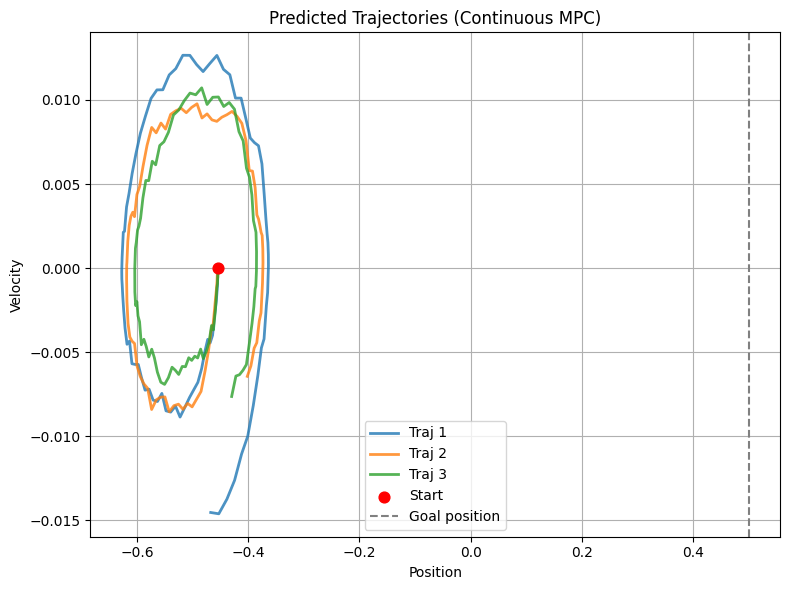

np.float64(-0.005827416852116585)

In [485]:
import numpy as np
import matplotlib.pyplot as plt

def low_discrepancy_eps(n_seq, H, sigma):
    """Deterministic perturbations in [-sigma, sigma]."""
    try:
        from scipy.stats import qmc
        try:
            eng = qmc.Sobol(d=H, scramble=False)
        except Exception:
            eng = qmc.Halton(d=H, scramble=False)
        X = eng.random_base2(m=int(np.ceil(np.log2(max(1, n_seq)))))[:n_seq]   # [0,1]
        return ((2.0 * X - 1.0) * sigma).astype(np.float32)
    except Exception:
        k = np.arange(1, n_seq + 1, dtype=np.float32)[:, None]
        t = np.arange(H, dtype=np.float32)[None, :]
        return (sigma * np.cos(2.0 * np.pi * (k * (t + 1)) / (n_seq + 1))).astype(np.float32)


class MPPIController:
    def __init__(self, H=100, N_seq=200, lamda=1.0, sigma=0.3, u_min=-1.0, u_max=1.0):
        """
        Model Predictive Path Integral Controller with persistent action sequence.
        Uses the best trajectory (lowest-cost) to update instead of weighted mean.
        """
        self.H = H
        self.N_seq = N_seq
        self.lamda = lamda      # Temperature parameter
        self.sigma = sigma

        self.u_min, self.u_max = float(u_min), float(u_max)

        # Persistent mean sequence for warm-start
        self.U_mean = np.zeros(H)

        # RNG

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, sigma = self.H, self.N_seq, self.sigma

        ######## TODO #############
        # 0 Shift previous mean sequence (reuse previous solution)
        if H > 1:
            self.U_mean[:-1] = self.U_mean[1:]
            self.U_mean[-1]  = self.U_mean[-2]

        # 1. Sample action sequences (Gaussian noise around previous U_mean)
        dU = low_discrepancy_eps(N_seq, H, self.sigma)                 # (N, H)
        U  = np.clip(self.U_mean[None, :] + dU, self.u_min, self.u_max)

        # 2. Roll out trajectories
        all_traj, S = roll_out_n_trajectories(state, U)            # S shape (N,)

        # 3. Select the best trajectory (lowest cost)
        S_min = float(S.min())
        w = np.exp(-(S - S_min) / max(1e-8, self.lamda))             # (N,)
        w_sum = w.sum() + 1e-12
        #self.U_mean = np.clip(self.U_mean + (w[:, None] * dU).sum(0) / w_sum, self.u_min, self.u_max)
        new_mean = self.U_mean + (w[:, None] * dU).sum(0) / (w.sum() + 1e-12)
        self.U_mean = 0.8 * self.U_mean + 0.2 * new_mean   # smoothing like your NumPy version

        #  Optional: plot best trajectories
        if plot:
            best_k = np.argsort(S)[:plot_best]
            best_traj = [all_traj[i] for i in best_k]
            plot_trajectories(state, best_traj)

        # 4. Return the first action of the best sequence
        best_action = self.U_mean[0]
        return best_action



# Initialize controller once
mppi = MPPIController(H=80, N_seq=210, lamda=1.0, sigma=0.6)

obs, _ = env.reset()
a = mppi.action(obs, plot=True, plot_best=3)  # plot first iteration only
a

In [ ]:
def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for entry in trajectory:
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Initialize controller once
#mppi = MPPIController(H=30, N_seq=200, lamda=.10, sigma=.50)
mppi = MPPIController(H=80, N_seq=150, lamda=1.0, sigma=2.1)

obs, _ = env.reset(seed=0)
traj = []

for t in range(300):
    a = mppi.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")

plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

In [468]:
import gymnasium as gym
import numpy as np

class HoldAtSetpointWrapper(gym.Wrapper):
    """
    Keep episode running and require the car to *hold* near x*=0.45 with tiny velocity
    for a few steps before we consider it "done".
    """
    def __init__(self, env, x_star=0.45, pos_tol=0.01, v_tol=0.003, hold_steps=12):
        super().__init__(env)
        self.x_star = float(x_star)
        self.pos_tol = float(pos_tol)
        self.v_tol = float(v_tol)
        self.hold_steps_req = int(hold_steps)
        self._hold = 0
        # expose for controller/reporting
        self.goal_position = float(getattr(env.unwrapped, "goal_position", x_star))

    def reset(self, **kw):
        self._hold = 0
        return self.env.reset(**kw)

    def step(self, action):
        s_next, r, terminated, truncated, info = self.env.step(action)
        x, v = float(s_next[0]), float(s_next[1])

        # override termination: we only "finish" after steady hold near setpoint
        near = abs(x - self.x_star) <= self.pos_tol
        slow = abs(v) <= self.v_tol
        if near and slow:
            self._hold += 1
        else:
            self._hold = 0

        # never terminate early for reaching 0.45; require sustained hold
        if terminated:
            terminated = (self._hold >= self.hold_steps_req)

        return s_next, r, terminated, truncated, info

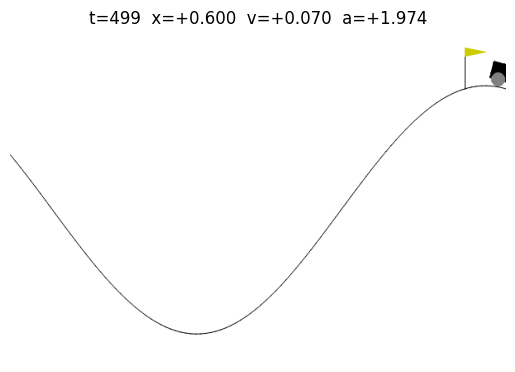

In [486]:
# make wrapped env for inline rendering
base_env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
env = HoldAtSetpointWrapper(base_env, x_star=0.45, pos_tol=0.001, v_tol=0.003, hold_steps=12)

# your MPPI controller (weighted update version)
mppi = MPPIController(H=80, N_seq=256, lamda=1.0, sigma=0.6)

# control loop with inline render (same pattern you used earlier)
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
obs, _ = env.reset(seed=0)

fig, ax = plt.subplots()
img = ax.imshow(env.render()); ax.axis("off"); display(fig)

done, t = False, 0
while not done and t < 500:
    a_val = mppi.action(obs, plot=False)               # MPPI chooses u_0
    a = np.array([a_val], dtype=np.float32)
    obs, r, terminated, truncated, _ = env.step(a)
    done = terminated or truncated

    # live preview
    img.set_data(env.render())
    ax.set_title(f"t={t}  x={obs[0]:+.3f}  v={obs[1]:+.3f}  a={a_val:+.3f}")
    clear_output(wait=True); display(fig); 
    plt.pause(0.001)

    t += 1

env.close()

Running Stop-at-Top MPPI
Held steady for 10 seconds at step 268. Terminating early.
Energy used: 92.92


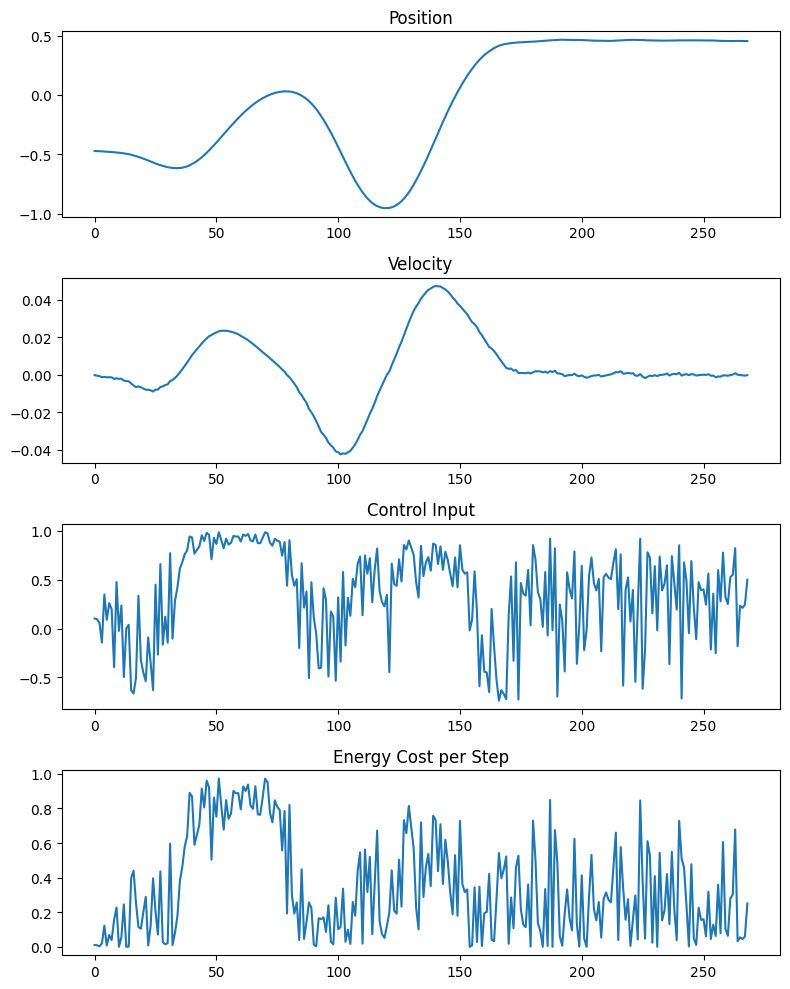


Running Energy-Saving MPPI
Held steady for 10 seconds at step 289. Terminating early.
Energy used: 102.47


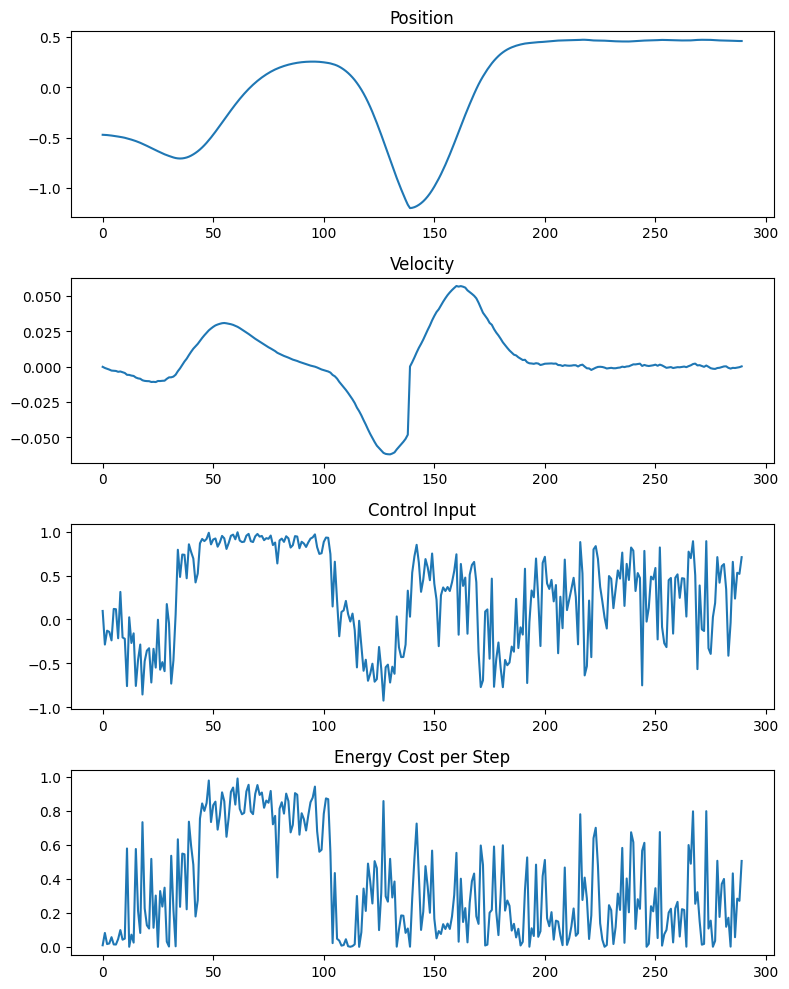

In [489]:
#import gym
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

CONFIG = dict(
    horizon = 80,
    k = 256,
    sigma = 0.6,
    lam = 1.0,
    gamma = 0.99,
    env_name = "MountainCarContinuous-v0",
    render_mode = "human",
)

STOP_WEIGHTS = dict(
    position = 800,
    velocity = 200,
    energy = 1.0,
    stop_boost = 5000.0,
    time = 2.0,
)
ENERGY_WEIGHTS = dict(
    position = 200,
    velocity = 400,
    energy = 10.0,
    stop_boost = 3000.0,
    time = 1.0,
)

def mountain_car_dynamics(p, v, a):
    v_next = v + 0.0015 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

def cost_fn(state, a, w):
    x, v = state
    goal = 0.45
    dist = abs(x - goal)
    pos = w["position"] * (np.tanh(dist * 2) ** 2)
    vel_weight = w["velocity"] + w["stop_boost"] * np.exp(-20 * dist)
    vel = vel_weight * (v**2)
    energy = w["energy"] * (a**2)
    time = w["time"]
    steady = -1000.0 if dist < 0.03 and abs(v) < 0.005 else 0.0
    return pos + vel + energy + time + steady

def roll_out_trajectory(s0, Ui, w, gamma=CONFIG["gamma"]):
    s = s0.copy()
    total = 0.0
    disc = 1.0
    for a in Ui:
        s = mountain_car_dynamics(s[0], s[1], a)
        total += cost_fn(s, a, w) * disc
        disc *= gamma
    return total

def roll_out_n_trajectories(state, U, w):
    k = len(U)
    J = np.zeros(k)
    for i in range(k):
        J[i] = roll_out_trajectory(state, U[i], w)
    return J

class MPPIController:
    def __init__(self, H, k, lam, sigma, w):
        self.H = H
        self.k = k
        self.lam = lam
        self.sigma = sigma
        self.w = w
        self.U_mean = np.zeros(H)

    def action(self, state):
        H, k, sigma, lam = self.H, self.k, self.sigma, self.lam
        self.U_mean[:-1] = self.U_mean[1:]
        self.U_mean[-1] = 0.0
        noise = np.random.randn(k, H) * sigma
        U = np.clip(self.U_mean[None, :] + noise, -1.0, 1.0)
        J = roll_out_n_trajectories(state, U, self.w)
        minJ = np.min(J)
        wts = np.exp(-(J - minJ) / (lam + 1e-6))
        wts /= np.sum(wts)
        new_mean = np.sum(U * wts[:, None], axis=0)
        self.U_mean = 0.8 * self.U_mean + 0.2 * new_mean
        return float(self.U_mean[0])

def run_mppi(w):
    env = gym.make(CONFIG["env_name"], render_mode=CONFIG["render_mode"])
    ctrl = MPPIController(CONFIG["horizon"], CONFIG["k"], CONFIG["lam"], CONFIG["sigma"], w)
    obs, _ = env.reset(seed=0)
    pos, vel, act = [], [], []

    hold_counter = 0
    for t in range(2000):
        a = ctrl.action(obs)
        obs, _, _, _, _ = env.step([a])
        pos.append(obs[0]); vel.append(obs[1]); act.append(a)

        # --- stop after holding near goal for ~10 seconds (~100 timesteps)
        if abs(obs[0] - 0.45) < 0.03 and abs(obs[1]) < 0.005:
            hold_counter += 1
        else:
            hold_counter = 0
        if hold_counter >= 100:
            print(f"Held steady for 10 seconds at step {t}. Terminating early.")
            break

    env.close()
    energy = np.sum(np.square(act))
    print(f"Energy used: {energy:.2f}")

    fig, axs = plt.subplots(4, 1, figsize=(8, 10))
    axs[0].plot(pos); axs[0].set_title("Position")
    axs[1].plot(vel); axs[1].set_title("Velocity")
    axs[2].plot(act); axs[2].set_title("Control Input")
    axs[3].plot(np.square(act)); axs[3].set_title("Energy Cost per Step")
    plt.tight_layout(); plt.show()

print("Running Stop-at-Top MPPI")
run_mppi(STOP_WEIGHTS)
print("\nRunning Energy-Saving MPPI")
run_mppi(ENERGY_WEIGHTS)

In [11]:
# ============================================================
# MPPI + Gaussian-Process Dynamics (fast, batched, “parks” at 0.45)
# ============================================================

import numpy as np
import torch
import gpytorch
import gymnasium as gym
import matplotlib.pyplot as plt

# ---------------- Device ----------------
DEVICE = torch.device("cuda")

# ---------------- Config ----------------
CONFIG = dict(
    horizon   = 140,   # longer horizon helps start braking earlier (80→110/120)
    k         = 256,   # number of sampled sequences
    sigma     = 0.45,   # exploration std (per action)
    lam       = 1.0,   # MPPI temperature
    gamma     = 0.99,  # discount for planning
    env_name  = "MountainCarContinuous-v0",
    render    = "human",
)

# ---------------- Ensure GP bits are present ----------------
# Expected from your GP training:
#   gp_models : list[(model, likelihood)]  for Δpos and Δvel
#   z_mean,z_std : (3,) torch
#   y_mean,y_std : (2,) torch
for name in ["gp_models", "z_mean", "z_std", "y_mean", "y_std"]:
    assert name in globals(), f"Missing '{name}'. Run your GP training cell first."

for i, (m, lk) in enumerate(gp_models):
    m.eval().to(DEVICE)
    lk.eval().to(DEVICE)
z_mean = z_mean.to(DEVICE)
z_std  = z_std.to(DEVICE)
y_mean = y_mean.to(DEVICE)
y_std  = y_std.to(DEVICE)

# ---------------- Batched GP predictor: Δx ----------------
@torch.no_grad()
def gp_dynamics_predict_t(x_t, u_t):
    """
    x_t: (K,2) torch.float32 on DEVICE
    u_t: (K,1) torch.float32 on DEVICE
    returns Δx: (K,2) torch.float32
    """
    z = torch.cat([x_t, u_t], dim=1)        # (K,3)
    z_n = (z - z_mean) / z_std

    outs = []
    for (m, lk) in gp_models:               # 2 heads: Δpos, Δvel
        dist = m(z_n)
        outs.append(lk(dist).mean)          # (K,)
    dx_n = torch.stack(outs, dim=1)         # (K,2)
    return dx_n * y_mean.new_tensor(y_std) + y_mean

@torch.no_grad()
def cost_fn_torch(
    x, a, a_prev=None, is_terminal_mask=None, tail_mask=None, *,
    goal=0.45,
    # base shaping
    w_pos=250.0, w_vel=60.0, w_act=1.0, tanh_gain=2.0,
    # early gating & braking / holding
    beta=20.0,                 # smaller -> starts braking earlier
    w_v_near=16000.0,          # strong brake near goal
    w_hold=9000.0,             # track u_eq near goal
    # asymmetry & barriers (to prevent overshoot)
    w_v_right=8000.0,          # penalize positive velocity near goal
    w_barrier=60000.0,         # big soft barrier when x>goal_eff
    barrier_power=4.0,         # steeper than quadratic
    # anti-rollback and overshoot torque sign
    w_rollback=2000.0, w_overshoot_u=12000.0,
    # stickiness (reward staying parked)
    band_pos=0.012, band_vel=0.010, perstep_stick_bonus=-20.0,
    terminal_arrival_bonus=-350.0,
    # smoothness & tail
    w_slew=0.03, w_tail=5.0,
    # model-bias cushion: shift target left when arriving fast
    margin_base=0.012, kv_margin=0.08,    # goal_eff = goal - (margin_base + kv*relu(v))
    # MPPI scaling
    w_time=0.0, scale=8.0
):
    """
    x: (N,2), a: (N,1)
    returns: (N,)
    """
    pos = x[..., 0]
    vel = x[..., 1]
    u   = torch.clamp(a[..., 0], -1.0, 1.0)

    # --- dynamic goal (cushion) ---
    # When moving right (vel>0), require stopping a bit before the flag.
    goal_eff = goal - (margin_base + kv_margin * torch.relu(vel))

    dist = (pos - goal_eff).abs()
    near = torch.exp(-beta * dist)  # ~1 near goal_eff, 0 far

    # base shaping (saturating position)
    pos_term = w_pos * (torch.tanh(tanh_gain * dist) ** 2)
    base     = w_vel * (vel**2) + w_act * (u**2)

    # near-goal brake
    v_near_term = w_v_near * near * (vel**2)

    # penalize RIGHTWARD velocity near crest specifically -> brake earlier
    v_right = torch.relu(vel)
    v_right_term = w_v_right * near * (v_right**2)

    # hold torque u_eq to balance gravity at crest
    u_eq = 1.6666667 * torch.cos(3.0 * pos)
    u_eq = torch.clamp(u_eq, -1.0, 1.0)
    hold_term = w_hold * near * ((u - u_eq)**2)

    # soft asymmetric barrier when x > goal_eff (prevents flying past)
    overshoot = torch.relu(pos - goal_eff)
    barrier_term = w_barrier * (overshoot ** barrier_power)

    # discourage negative torque near crest (rolling back)
    rollback_term = w_rollback * near * torch.relu(-u)

    # if overshooting and still commanding negative torque, extra penalty
    over_wrong_u = w_overshoot_u * torch.relu(-u) * (overshoot > 0).float()

    # stickiness reward for being parked
    parked = (dist <= band_pos) & (vel.abs() <= band_vel)
    stick = perstep_stick_bonus * parked.float()

    # smoothness
    if a_prev is not None and w_slew > 0.0:
        u_prev = torch.clamp(a_prev[..., 0], -1.0, 1.0)
        slew = w_slew * ((u - u_prev)**2)
    else:
        slew = 0.0

    # tail penalty (last M steps -> prefer small actions for parking)
    if tail_mask is not None and w_tail > 0.0:
        tail_term = w_tail * (u**2) * tail_mask.to(x.dtype)
    else:
        tail_term = 0.0

    # terminal emphasis
    if is_terminal_mask is not None:
        term = 3.0 * (vel**2) + 1.0 * ((pos - goal_eff)**2) + terminal_arrival_bonus * parked.float()
        term = term * is_terminal_mask.to(x.dtype)
    else:
        term = 0.0

    time_term = torch.as_tensor(w_time, dtype=x.dtype, device=x.device)

    cost = (pos_term + base + v_near_term + v_right_term + hold_term +
            barrier_term + rollback_term + over_wrong_u +
            stick + slew + tail_term + term + time_term)

    return cost / scale


# ---------------- Fast batched rollout on DEVICE ----------------
@torch.no_grad()
def roll_out_n_trajectories(state, U, gamma=0.99, scale=8.0, tail_M=10, profile="STOP"):
    """
    state: (2,) numpy
    U    : (N,H) numpy actions in [-1,1]
    returns: all_traj(list of N (H+1,2) arrays), J (N,)
    """
    # Optional: tweak base penalties by profile
    if profile == "STOP":
        w_pos, w_vel, w_act = 300.0, 80.0, 1.0
    else:  # "ENERGY"
        w_pos, w_vel, w_act = 200.0, 120.0, 10.0

    s0 = torch.as_tensor(state, dtype=torch.float32, device=DEVICE).view(1,2)
    Ut = torch.as_tensor(U,     dtype=torch.float32, device=DEVICE)         # (N,H)
    N, H = Ut.shape

    s = s0.expand(N, 2).clone()
    traj = torch.empty(N, H+1, 2, device=DEVICE, dtype=torch.float32)
    traj[:, 0] = s

    J = torch.zeros(N, device=DEVICE, dtype=torch.float32)
    a_prev = torch.zeros(N, 1, device=DEVICE, dtype=torch.float32)
    disc = 1.0

    with gpytorch.settings.fast_pred_var():
        for t in range(H):
            u_t = Ut[:, t:t+1].clamp_(-1.0, 1.0)                   # (N,1)
            dx  = gp_dynamics_predict_t(s, u_t)                    # (N,2)
            s   = s + dx

            # MC physical clamps → keep plans realistic
            s[:, 1] = torch.clamp(s[:, 1], -0.07, 0.07)
            s[:, 0] = torch.clamp(s[:, 0], -1.2,  0.6)
            hit_left = s[:, 0] <= -1.2 + 1e-12
            s[hit_left, 1] = 0.0

            traj[:, t+1] = s

            is_term = (torch.ones(N, device=DEVICE) if t == H-1 else torch.zeros(N, device=DEVICE))
            tail_mask = (torch.ones(N, device=DEVICE) if t >= H - tail_M else torch.zeros(N, device=DEVICE))

            step_cost = cost_fn_torch(
                s, u_t, a_prev=a_prev, is_terminal_mask=is_term, tail_mask=tail_mask,
                w_pos=w_pos, w_vel=w_vel, w_act=w_act, scale=scale
            )  # (N,)
            J.add_(step_cost.view(-1) * disc)
            disc *= gamma
            a_prev = u_t

    traj_np = traj.detach().cpu().numpy()
    J_np    = J.detach().cpu().numpy()
    all_traj = [traj_np[i] for i in range(N)]
    return all_traj, J_np

# ---------------- AR(1) correlated noise ----------------
def ar1_noise(K, H, sigma=0.6, rho=0.9):
    z = np.random.randn(K, H).astype(np.float32)
    eps = np.zeros_like(z)
    eps[:, 0] = sigma * z[:, 0]
    step = sigma * np.sqrt(max(1e-12, 1.0 - rho**2))
    for t in range(1, H):
        eps[:, t] = rho * eps[:, t-1] + step * z[:, t]
    return eps

# ---------------- MPPI Controller ----------------
class MPPIController:
    def __init__(self, H, k, lam, sigma, profile="STOP", gamma=0.99, scale=8.0, tail_M=10):
        self.H = int(H)
        self.k = int(k)
        self.lam = float(lam)
        self.sigma = float(sigma)
        self.profile = profile
        self.gamma = float(gamma)
        self.scale = float(scale)
        self.tail_M = int(tail_M)
        self.U_mean = np.zeros(self.H, dtype=np.float32)

    def action(self, state):
        H, K = self.H, self.k
        # recede horizon + encourage coasting at far tail
        if H > 1:
            self.U_mean[:-1] = self.U_mean[1:]
            self.U_mean[-1]  = 0.0

        # AR(1) correlated noise around mean
        noise = ar1_noise(K, H, sigma=self.sigma, rho=0.9)
        U = np.clip(self.U_mean[None, :] + noise, -1.0, 1.0)  # (K,H)

        # Evaluate with fast GP rollout
        _, J = roll_out_n_trajectories(state, U, gamma=self.gamma, scale=self.scale,
                                       tail_M=self.tail_M, profile=self.profile)

        # MPPI weights
        Jmin = float(J.min())
        w = np.exp(-(J - Jmin) / (self.lam + 1e-12))
        w /= (w.sum() + 1e-12)

        # smoothed update (prevents lurching)
        new_mean = (w[:, None] * U).sum(axis=0)
        self.U_mean = 0.8 * self.U_mean + 0.2 * new_mean

        return float(self.U_mean[0])

# ---------------- Runner ----------------
def run_mppi(profile="STOP", seed=0, max_steps=2000):
    env = gym.make(CONFIG["env_name"], render_mode=CONFIG["render"])
    ctrl = MPPIController(CONFIG["horizon"], CONFIG["k"], CONFIG["lam"], CONFIG["sigma"],
                          profile=profile, gamma=CONFIG["gamma"], scale=8.0, tail_M=10)
    obs, _ = env.reset(seed=seed)
    pos, vel, act = [], [], []
    hold_counter = 0

    for t in range(max_steps):
        a = ctrl.action(obs)
        obs, _, terminated, truncated, _ = env.step([a])
        pos.append(obs[0]); vel.append(obs[1]); act.append(a)

        # hold detection (10s ≈ 100 steps)
        if abs(obs[0] - 0.45) < 0.03 and abs(obs[1]) < 0.005:
            hold_counter += 1
        else:
            hold_counter = 0
        if hold_counter >= 100:
            print(f"Held steady ~10s at step {t}. Stopping.")
            break

        # if terminated or truncated:
        #     break

    env.close()
    energy = float(np.sum(np.square(act)))
    print(f"[{profile}] Energy used: {energy:.2f}")

    fig, axs = plt.subplots(4, 1, figsize=(8, 10))
    axs[0].plot(pos); axs[0].set_title("Position")
    axs[1].plot(vel); axs[1].set_title("Velocity")
    axs[2].plot(act); axs[2].set_title("Control Input")
    axs[3].plot(np.square(act)); axs[3].set_title("Energy per Step")
    plt.tight_layout(); plt.show()

# ---------------- Example runs ----------------
print("Running Stop-at-Top MPPI (GP dynamics)")
run_mppi("STOP", seed=0)
print("\nRunning Energy-Saving MPPI (GP dynamics)")
run_mppi("ENERGY", seed=0)


Running Stop-at-Top MPPI (GP dynamics)


/tmp/ipykernel_142773/370896812.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  return dx_n * y_mean.new_tensor(y_std) + y_mean


KeyboardInterrupt: 